## Assignment 2

### Task:

1. Randomly select 3 classes with 100 images per class for this assignment.
2. Build the autoencoder model using CNN with functioning training code (if not CNN based, 60% reduction of marks will incur for this task).
3. Plot the learnt images 2D coordinates (normally called embeddings in machine learning) of all images in training with each class denoted b a symbol, for example, circles for dogs, triangles for cats and so on.
4. Randomly select 5 images that are not in the training set and obtain their 2D representations, add them to the plot produced in task 3 and describe what do you.
think about them in terms of their locations in relations to others. Your code should produce the plot similar to Fig 1.

### Bonus Task:

Build a supervised manifold learning model on CIFAR-10 images. The main idea is to incorporate labels information in the manifold learning process. It is very similar to LDA (linear discriminant analysis) in terms of functionality. However, instead of a lienar function, we use neural networks autoencoder as the backbone for manifold learning. Therefore, the model is a combination of autoencoder and classification, i.e. incorporating supervision information inthe modelling process, for exmaple, addding classification cost function into original autoencoder cost function. Do task 1-4 (see above) but replace the autoencoder by this supervised one.

**NOTE: this is extra 10 marks contributing towards your final scores if you can do it**

## WORKING SECTION

In [4]:
# Import libraries and packages that will be used throughout the assignment
import numpy as np
import torch
import random
import torchvision
import os
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pandas as pd

# Random split modules 
from torch.utils.data import random_split
from torch.utils.data import DataLoader

# Load and normalise CIFAR10
from torchvision.datasets import CIFAR10
from torchvision import transforms

#neural network training
from torch import nn
from torch.nn import ConvTranspose2d

### Question 1:

In [5]:
# Download and load the image dataset from CIFAR10 packages
torch.manual_seed(0)
CIF_dataset = CIFAR10(os.getcwd(), transform = transforms.ToTensor(), download = True) # CIFAR dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

100.0%


Extracting c:\machine_learning\cifar-10-python.tar.gz to c:\machine_learning


In [4]:
# Randomly choose 3 classes from this dataset for future analysis
random.seed(3)
random.sample(range(0,9),3)

[3, 2, 7]

We now have the selected random classes: 3, 2, and 7. The classes will be assigned for bird, automobile, and frog

In [6]:
#From CIFAR-10 dataset, we select 100 images for each of the 3 classes:
row_1 = list(np.where(np.array(CIF_dataset.targets) == 3)[0])[0:100]
row_2 = list(np.where(np.array(CIF_dataset.targets) == 2)[0])[0:100]
row_3 = list(np.where(np.array(CIF_dataset.targets) == 7)[0])[0:100]
row_binded = row_1 + row_2 + row_3

for i in range(10):
    random.Random(i).shuffle(row_binded) #shuffle 10 times

In [7]:
# use subset to bind rows that matched:
CIF_dataset1 = torch.utils.data.Subset(CIF_dataset, row_binded)
len(CIF_dataset) # 300 images for 3 classes (100 images per class)

50000

In [8]:
# Create sets for training, valdating and testing
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(CIF_dataset1, [100,100,100])

# Load data
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 5, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = 5, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 5, shuffle = False)

### Question 2

We will now create an Convolutional Neural Network AutoEncoder having the bottleneck layer output as 2 units.

Based on some researched information, the layer size can be determined as follows:

- CONVOLUTIONAL LAYER : (W - F + 2P)/S + 1
- TRANSPOSED CONVOLUTIONAL LAYER: (W - 1) * S - 2P + F
- W = input size (default = 0)
- F = kernel_size (default = 0)
- P = padding (default = 0)
- S = stride (default = 1)

In [9]:
# CNN AUTOENCODER
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # N, 3, 32 * 32 size
        self.encoder_layer = nn.Sequential(
            # Conv_layer block 1
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, padding = 2), # 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(inplace = True),

            # Conv_layer block 2
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding = 1), # 16 x 32 x 32
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 x 16 x 16
            
            # Conv_layer block 3
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 5, padding = 2), # 16 x 16 x 16
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 x 8 x 8

            # Conv_layer block 4
            nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, padding = 1), # 8 x 8 x 8
            nn.ReLU(inplace = True),
            )
        
        self.bottle_neck = nn.Sequential(
            nn.Linear(8 * 8 * 8, 2) # there are 2 units as output
            )
    
        self.decoder_layer = nn.Sequential(
            # Deconv_layer block 1
            nn.ConvTranspose2d(in_channels = 8, out_channels = 16, kernel_size = 2, stride = 2), # 16 x 16 x 16
            nn.ReLU(inplace = True),

            # Deconv_Layer block 2
            nn.ConvTranspose2d(in_channels = 16, out_channels = 32, kernel_size = 2, stride = 2), # 32 x 32 x 32
            nn.ReLU(inplace = True),

            # Deconv_Layer block 3
            nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 3, padding = 1), # 3 x 32 x 32 #the output is the same as the input
            nn.ReLU(inplace = True)
            )
        
    def forward(self, x):
        # encoder_layer
        encoder_val = self.encoder_layer(x)

        # bottleneck_layer
        bottle_neck = encoder_val.view(encoder_val.size(0), - 1) # in terms of dimensionality, we fix it to be 2
        bottle_neck = self.bottle_neck(bottle_neck)

        # decoder_layer
        x = self.decoder_layer(encoder_val)

        return bottle_neck, x
    
model = CNNAutoEncoder()

And then we move onto creating a function to help train the CNN AutoEncoder model declared above, the required values to be inserted into the function will mainly consist of:
- Optimiser
- Chosen model
- Loss function
- Train dataloader
- Validation dataloader
- Number of epochs
- etc

In [12]:
def AutoEncoder_model_training(optimiser, model,
                               Loss_function,
                               train_loader, 
                               val_loader,
                               n_epochs = 10, fplotloss = True, #fdraw = False,
                               filename = ''):
    train_on_gpu = torch.cuda.is_available()
    if train_on_gpu:
        print("GPU available! Train model on GPU.")
        model.cuda()

    # tracking
    train_LossList = []
    val_LossList = []

    val_Loss_Min = np.inf

    # Entering Training Cycles
    print("Entering training cycles with CNN AutoEncoder")
    for epoch in [*range(n_epochs)]:

        # keeping tacking of training loss and validation loss
        train_Loss = 0.0
        val_Loss = 0.0

        # for train model
        model.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # clear gradient of all optimised variables
            optimiser.zero_grad()

            #f orward pass: predicted outputs by passing inputs to the model
            output = model(data)

            # batch loss:
            Batch_Loss = Loss_function(output[1], data)

            # backward pass: compute gradients of the loss with respect to model parameters
            Batch_Loss.backward()

            # optimisation step (parameter update)
            optimiser.step()

            # update training Loss
            train_Loss += Batch_Loss.item() * data.size(0)

        # validate the model
        model.eval()
        for data, target in val_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # forward pass: predicts outputs by passing inputs to the model
            output = model(data)

            # batch_loss:
            Batch_Loss = Loss_function(output[1], data)

            # Update validation loss:
            val_Loss += Batch_Loss.item() * data.size(0)

        # Calculate avg losses
        train_Loss = train_Loss / len(train_loader.dataset)
        val_Loss = val_Loss / len(val_loader.dataset)

        # append the Loss values to the Loss lists declared
        train_LossList.append(train_Loss)
        val_LossList.append(val_Loss)

        # print the statistics
        print('Epoch: {} \tTraining_Loss: {:.6f} \t Validation_Loss: {:.6f}'.format(epoch, train_Loss, val_Loss))

        # if validation loss decreased
        if val_Loss <= val_Loss_Min: # print if val loss decreased
            print('Validation Loss decreased: ({:.6f} --> {:.6f}). Saving.'.format(val_Loss_Min, val_Loss))
            torch.save(model.state_dict(), 'bestCNNAutoEncoder_model' + filename + '.pt') # we then proceed onto saving the best model
            val_Loss_Min = val_Loss

    # Plot Training and Validation Loss if fplotloss = True
    if fplotloss == True:
        plt.plot(*range(n_epochs), train_LossList)
        plt.plot(*range(n_epochs), val_LossList)
        plt.ylim((min(train_LossList + val_LossList), max(train_LossList + val_LossList)))
        plt.xlabel('Epoch_n:')
        plt.ylabel('Loss')
        plt.title('Model Performance')
        plt.legend(['Training Loss', 'Validation Loss'])
        plt.show()
    # Cycles is complete
    print('Training process is now completed')

We are now going to train the model.

With this problem, we would want to train the model until it becomes the best model, so that we can use it to visualise the images from the bottleneck layer of the CNN AutoEncoder model above onto a 2D coordinate graph. We will train the model as follows:

Entering training cycles with CNN AutoEncoder
Epoch: 0 	Training_Loss: 0.235304 	 Validation_Loss: 0.221283
Validation Loss decreased: (inf --> 0.221283). Saving.
Epoch: 1 	Training_Loss: 0.215492 	 Validation_Loss: 0.207244
Validation Loss decreased: (0.221283 --> 0.207244). Saving.
Epoch: 2 	Training_Loss: 0.204790 	 Validation_Loss: 0.200235
Validation Loss decreased: (0.207244 --> 0.200235). Saving.
Epoch: 3 	Training_Loss: 0.199374 	 Validation_Loss: 0.196751
Validation Loss decreased: (0.200235 --> 0.196751). Saving.
Epoch: 4 	Training_Loss: 0.196656 	 Validation_Loss: 0.195057
Validation Loss decreased: (0.196751 --> 0.195057). Saving.
Epoch: 5 	Training_Loss: 0.195312 	 Validation_Loss: 0.194262
Validation Loss decreased: (0.195057 --> 0.194262). Saving.
Epoch: 6 	Training_Loss: 0.194667 	 Validation_Loss: 0.193916
Validation Loss decreased: (0.194262 --> 0.193916). Saving.
Epoch: 7 	Training_Loss: 0.194360 	 Validation_Loss: 0.193762
Validation Loss decreased: (0.193916 --> 0.

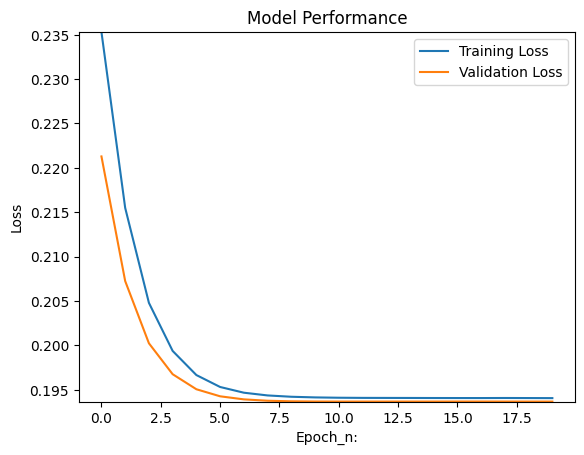

Training process is now completed


In [14]:
# train the model to the best model
model = CNNAutoEncoder()
optimiser = torch.optim.SGD(model.parameters(), lr = 0.01) # We will use stochastic gradient descent as an optimiser for this model

AutoEncoder_model_training(optimiser, model, 
                           nn.MSELoss(), #Mean Squared Error Loss
                           train_loader, val_loader,
                           n_epochs = 20, fplotloss= True, filename= '_ver1')

We will now load the best model from all the trained model

In [16]:
#load the best trained model:
model.load_state_dict(torch.load('C:/machine_learning/bestCNNAutoEncoder_model_ver1.pt'))

C:\Users\22027453\AppData\Local\Temp\ipykernel_18176\389394784.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/machine_learning/best

<All keys matched successfully>

### Question 3

In this question, we will use the output that was produced by the bottle neck layer of the best model as (X, y) coordinates of each images from the training dataset, and plot it into a 2D graph. From the 'test_loader' dataset, we will plot 5 images new images coordinates after having it trained through the loaded best model above.

The markers assigned to the classes are as follows:
- Bird class will be brown downward triangles 
- Automobiles will be purple octagons 
- Frogs will be green stars

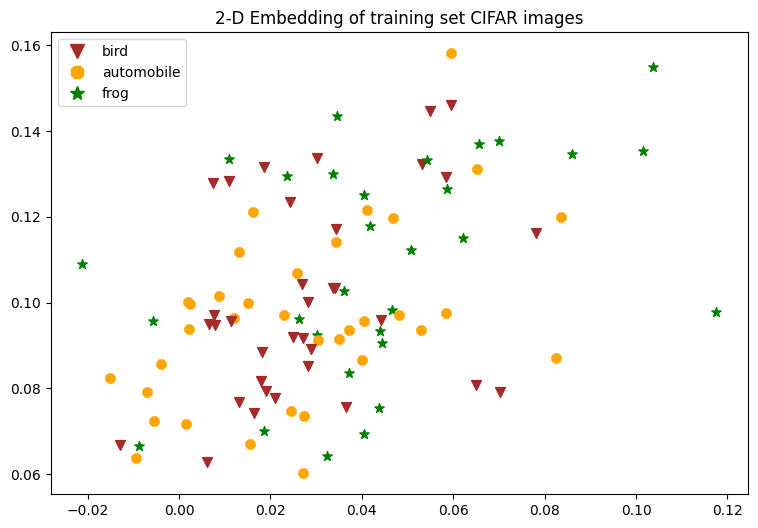

In [21]:
# Creating markers for each input of images
X_sym = {3: 'v', 2: '8' , 7: '*'}
X_col = {3: 'brown', 2: 'orange', 7:'green'}
marker_1 = mlines.Line2D([],[], color = 'brown', marker = 'v', linestyle = 'None', markersize = 10, label = 'bird')
marker_2 = mlines.Line2D([],[], color = 'orange', marker = '8', linestyle = 'None', markersize = 10, label = 'automobile')
marker_3 = mlines.Line2D([],[], color = 'green', marker = '*', linestyle = 'None', markersize = 10, label = 'frog')

plt.figure(figsize = (9,6))

# Plotting dataset from the train_loader:
for a in train_loader:
    lbls = a[1]
    output_btn, x_decoded = model(a[0])
    output_plot = pd.DataFrame(data = output_btn.detach().numpy())
    output_plot['labels'] = lbls.detach().numpy()
    output_plot['color'] = output_plot['labels'].replace(X_col)
    output_plot['symbols'] = output_plot['labels'].replace(X_sym)
    for i in range(len(output_plot)):
        plt.scatter(output_plot[0][i], output_plot[1][i], c = output_plot['color'][i], marker = output_plot['symbols'][i], s = 50)
plt.title('2-D Embedding of training set CIFAR images')

# Adding the legend for the plot
plt.legend(handles = [marker_1, marker_2, marker_3])

### Question 4

The 5 new images will be assigned with blue diamonds

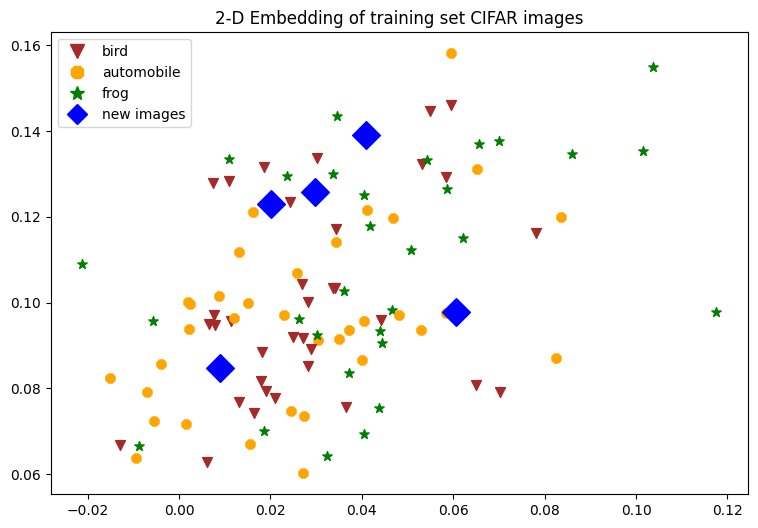

In [29]:
# Creating markers for each input of images
X_sym = {3: 'v', 2: '8' , 7: '*'}
X_col = {3: 'brown', 2: 'orange', 7:'green'}
marker_1 = mlines.Line2D([],[], color = 'brown', marker = 'v', linestyle = 'None', markersize = 10, label = 'bird')
marker_2 = mlines.Line2D([],[], color = 'orange', marker = '8', linestyle = 'None', markersize = 10, label = 'automobile')
marker_3 = mlines.Line2D([],[], color = 'green', marker = '*', linestyle = 'None', markersize = 10, label = 'frog')
marker_4 = mlines.Line2D([],[], color = 'blue', marker = 'D', linestyle = 'None', markersize = 10, label = 'new images')

plt.figure(figsize = (9,6))

#for plotting dataset from the train_loader:
for a in train_loader:
    lbls = a[1]
    output_btn, x_decoded = model(a[0])
    output_plot = pd.DataFrame(data = output_btn.detach().numpy())
    output_plot['labels'] = lbls.detach().numpy()
    output_plot['color'] = output_plot['labels'].replace(X_col)
    output_plot['symbols'] = output_plot['labels'].replace(X_sym)
    for i in range(len(output_plot)):
        plt.scatter(output_plot[0][i], output_plot[1][i], c = output_plot['color'][i], marker = output_plot['symbols'][i], s = 50)

plt.title('2-D Embedding of training set CIFAR images')

# for plotting the 5 new images from the test_loader:
i = 0
for a in test_loader:
    if i <= 1:
        lbls = a[1]
        output_btn, x_decoded = model(a[0])
        output_plot = pd.DataFrame(data = output_btn.detach().numpy())
        output_plot['labels'] = lbls.detach().numpy()
        output_plot['color'] = 'blue'
        output_plot['symbols'] = 'D'
        for i in range(len(output_plot)):
            plt.scatter(output_plot[0][i], output_plot[1][i], c = output_plot['color'][i], marker = output_plot['symbols'][i], s = 200)

plt.legend(handles = [marker_1, marker_2, marker_3, marker_4])

Based on the visualisation above, comments can be made about the positions of 5 new images:

- The first image is positioned near the left bottom part of the plot, with coordinates (X,y) is (0.01, 0.08). We can see that it is surrounded with data points from all three classes, therefore it may belong to either one of the three.
- The second image is positioned above the first with the coordinates (X,y) of (0.02, 0.12). Its closest data points belong to bird class and automobile class, but it seems that the automobile class has more data points. So the image could potentially belong to automobile class.
- The third image is positioned right next to the second with coordiantes (X,y) of (0.03, 0.12). It is surrounded with all three classes so it may belong to either of the classes.
- The fourth is located at (0.04, 0.14), and it is surrounded mostly with frog and bird class. Therefore, it may belong to either of the two classes.
- The fifth image (0.06, 0.10) can be seen being around data points from automobile class, so there is a very high chance that it belongs to automobile class.